In [1]:
import pandas as pd

from utils import load_parquet_to_df_list, z_normalize
from approximation.paa import PAA
from discretization.sax.sax import SAX
from discretization.sax.symbol_mapping import IntervalNormMedian, MeanValuePoints, IntervalMean, MedianValuePoints

<AxesSubplot: >

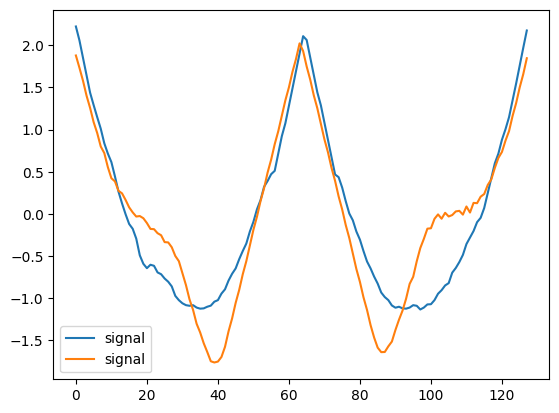

In [2]:
# load time series dataset into dataframe and z-normalize it
path = "../../../0_data/UCRArchive_2018/SwedishLeaf/train"
df_list = load_parquet_to_df_list(path)


# only select columns with data ('signal') and ignore class labels ('pattern_main_id')
df_norm = pd.concat([z_normalize(df["signal"].to_frame()) for df in df_list], axis=1).iloc[:, :2]
df_norm.plot()

In [3]:
# transform time series dataset into its PAA representation with a window size of 8 --> 128/6 = 21 segments
# 2 remaining points that get lost, because 2 <= 6/2 = 3
paa = PAA(window_size=5)
df_paa = paa.transform(df_norm)
df_paa

,signal,signal
0,1.842467,1.570372
1,1.000286,0.824302
2,0.287762,0.297420
3,-0.335774,-0.003486
4,-0.655818,-0.190993
5,-0.886941,-0.426893
6,-1.086975,-1.002528
7,-1.096749,-1.619739
8,-0.874207,-1.533341
9,-0.438173,-0.722811


In [4]:
# transform time series PAA representation into its SAX representation with an alphabet size of 4 (a, b, c, d)
# every PAA value is assigned a letter based on its value
sax = SAX(alphabet_size=5)
df_sax = sax.transform(df_paa)
df_sax

,signal,signal
0,e,e
1,e,d
2,d,d
3,b,c
4,b,c
5,a,b
6,a,a
7,a,a
8,a,a
9,b,b


<AxesSubplot: >

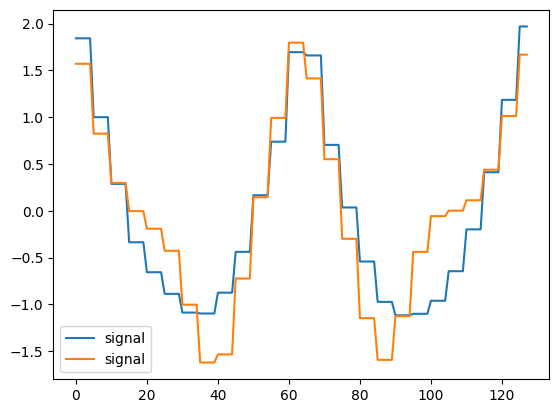

In [5]:
# inverse transformation of PAA representation, where every point is assigned the PAA value in its segment
df_paa_inv = paa.inv_transform(df_paa, df_norm.shape[0])
df_paa_inv.plot()

In [6]:
df_paa_inv

,signal,signal
0,1.842467,1.570372
1,1.842467,1.570372
2,1.842467,1.570372
3,1.842467,1.570372
4,1.842467,1.570372
...,...,...
123,1.184989,1.012551
124,1.184989,1.012551
125,1.968832,1.668139
126,1.968832,1.668139


In [7]:
# use median of respective intervals under standard normal distribution as a strategy to map symbol values to SAX symbols
symbol_mapping = IntervalNormMedian(sax.alphabet_size)
df_sax_inv = sax.inv_transform(df_sax, df_norm.shape[0], paa.window_size, symbol_mapping)
df_sax_inv

,signal,signal
0,1.281552,1.281552
1,1.281552,1.281552
2,1.281552,1.281552
3,1.281552,1.281552
4,1.281552,1.281552
...,...,...
123,1.281552,1.281552
124,1.281552,1.281552
125,1.281552,1.281552
126,1.281552,1.281552


<AxesSubplot: >

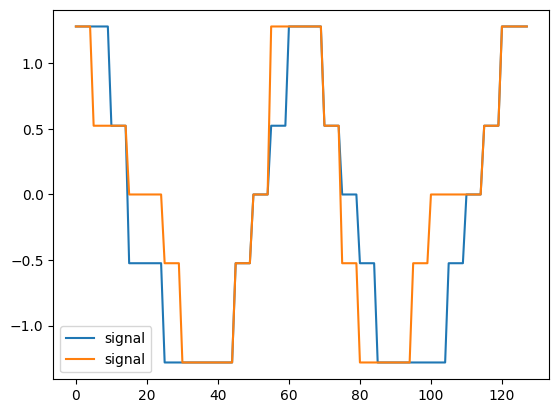

In [8]:
# is coarser than inverse transformation of PAA, because different PAA values can get mapped to the same symbol
# when inverse transforming PAA, points in segments which would have the same symbol get different values according to their mean (PAA value)
# but for SAX, points in segments with the same symbol get the same value, because one symbol is mapped to one value
df_sax_inv.plot()

In [9]:
# use mean of original (normalized) points in respective intervals as a strategy to map symbol values to SAX symbols
symbol_mapping = MeanValuePoints(df_norm)
df_sax_inv = sax.inv_transform(df_sax, df_norm.shape[0], paa.window_size, symbol_mapping)
df_sax_inv

,signal,signal
0,1.507132,1.416357
1,1.507132,1.416357
2,1.507132,1.416357
3,1.507132,1.416357
4,1.507132,1.416357
...,...,...
123,1.507132,1.416357
124,1.507132,1.416357
125,1.507132,1.416357
126,1.507132,1.416357


<AxesSubplot: >

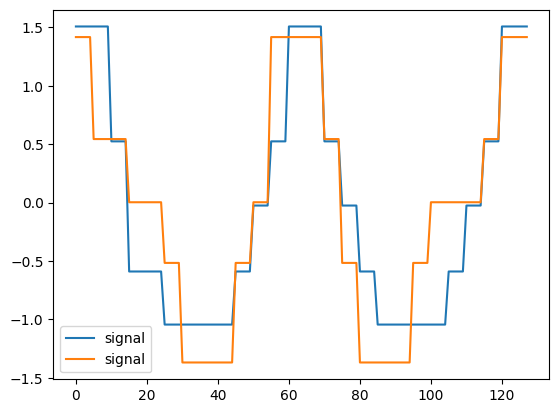

In [10]:
df_sax_inv.plot()

In [11]:
# use median of original (normalized) points in respective intervals as a strategy to map symbol values to SAX symbols
symbol_mapping = MedianValuePoints(df_norm)
df_sax_inv = sax.inv_transform(df_sax, df_norm.shape[0], paa.window_size, symbol_mapping)
df_sax_inv

,signal,signal
0,1.465004,1.404763
1,1.465004,1.404763
2,1.465004,1.404763
3,1.465004,1.404763
4,1.465004,1.404763
...,...,...
123,1.465004,1.404763
124,1.465004,1.404763
125,1.465004,1.404763
126,1.465004,1.404763


<AxesSubplot: >

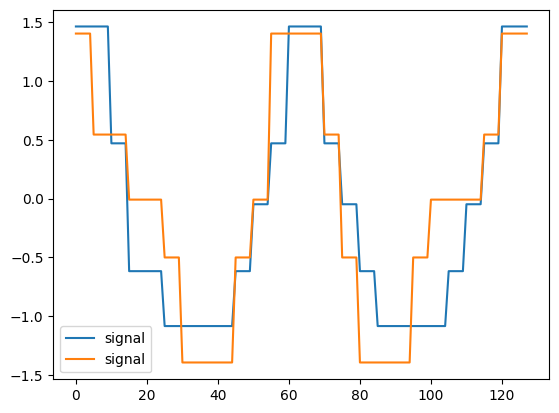

In [12]:
df_sax_inv.plot()

In [13]:
# use the means of the breakpoint intervals as a strategy to map symbol values to SAX symbols
bound = df_norm.to_numpy().min()
# bound = sax.breakpoints[0] * 1.5 this does not work very well
symbol_mapping = IntervalMean(bound)
df_sax_inv = sax.inv_transform(df_sax, df_norm.shape[0], paa.window_size, symbol_mapping)
df_sax_inv

,signal,signal
0,1.303079,1.303079
1,1.303079,1.303079
2,1.303079,1.303079
3,1.303079,1.303079
4,1.303079,1.303079
...,...,...
123,1.303079,1.303079
124,1.303079,1.303079
125,1.303079,1.303079
126,1.303079,1.303079


<AxesSubplot: >

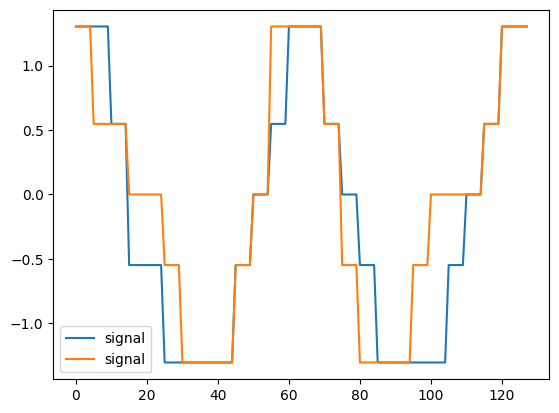

In [14]:
df_sax_inv.plot()

In [15]:
# compute SAX distance between all SAX representations
ts_size = df_norm.shape[0]
sax_distance_matrix = sax.distance(df_sax, ts_size)
sax_distance_matrix

,signal,signal
signal,0.000000,1.305263
signal,1.305263,0.000000
